**Import the required libraries**

In [111]:
from warnings import filterwarnings as f
f('ignore')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.feature_selection import RFE
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.metrics import *
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
pd.set_option('display.float_format',lambda x : '%.6f' %x)

In [15]:
bank = pd.read_csv('bank.csv')
bank.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,32,205,2,999,0,1.100000,93.994000,-36.400000,4.858000,5191.000000,no
1,32,691,10,999,0,1.400000,93.918000,-42.700000,4.960000,5228.100000,yes
2,45,45,8,999,0,1.400000,93.444000,-36.100000,4.963000,5228.100000,no
3,33,400,1,5,2,-1.100000,94.601000,-49.500000,1.032000,4963.600000,yes
4,47,903,2,999,1,-1.800000,93.075000,-47.100000,1.415000,5099.100000,yes


In [16]:
bank.shape

(9640, 11)

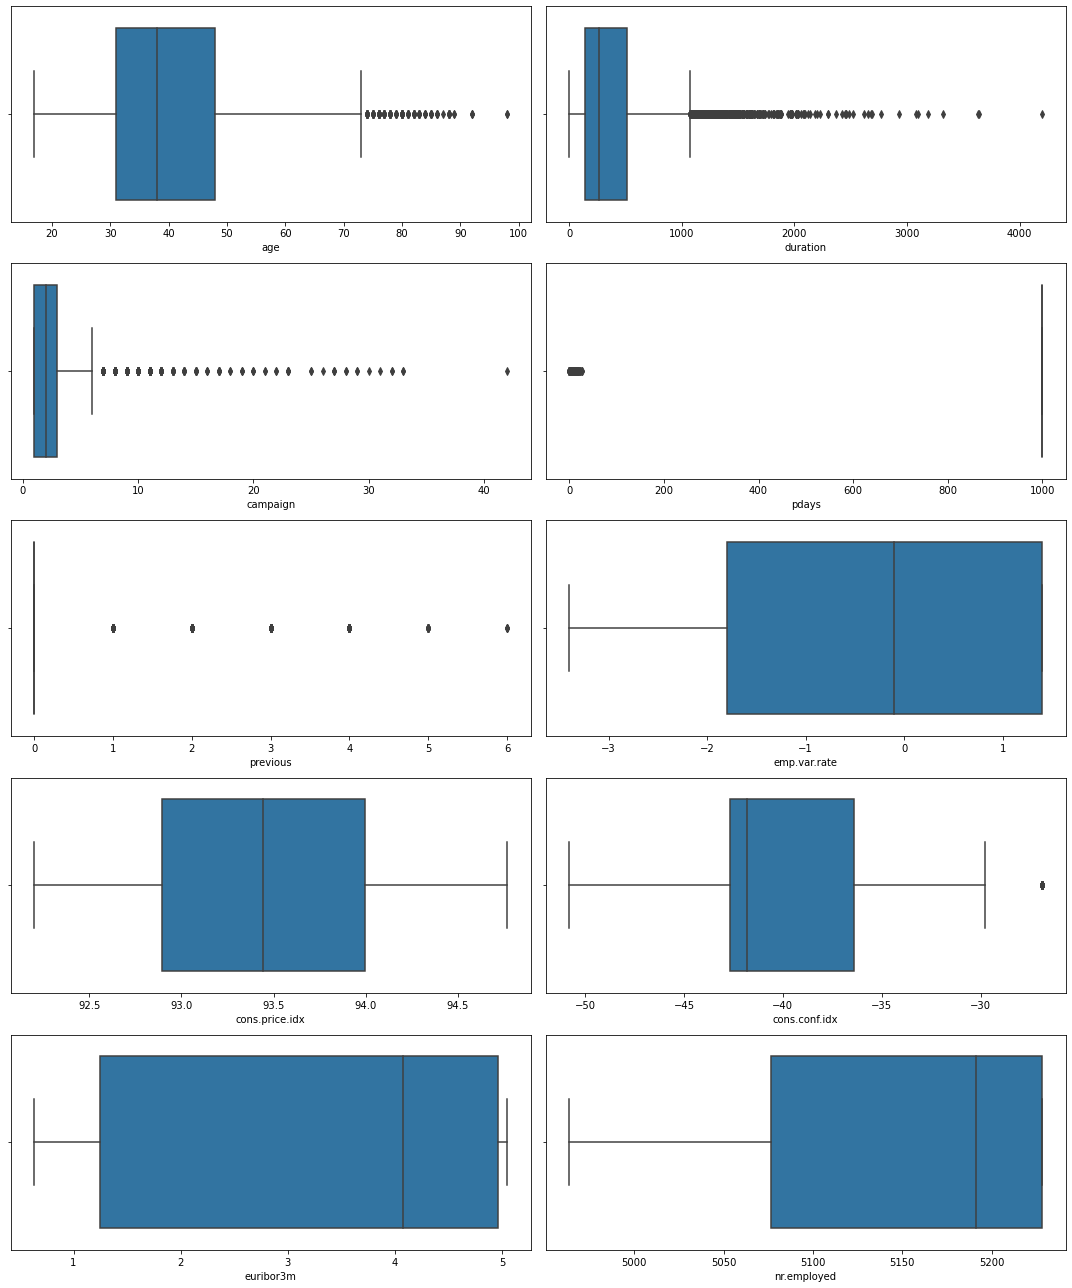

In [10]:
fig,ax = plt.subplots(nrows = 5,ncols=2,figsize = (15,18))
for var, subplot in zip(bank.columns[:-1],ax.flatten()):
    sns.boxplot(x = bank[var],ax=subplot);
plt.tight_layout()

In [42]:
q1 = bank.quantile(0.25)
q3 = bank.quantile(0.75)
iqr = q3 - q1

In [62]:
bank_capped = bank[~((bank < q1 - (1.5 * iqr)) | (bank > q3 + (1.5 * iqr))).any(axis=1)]

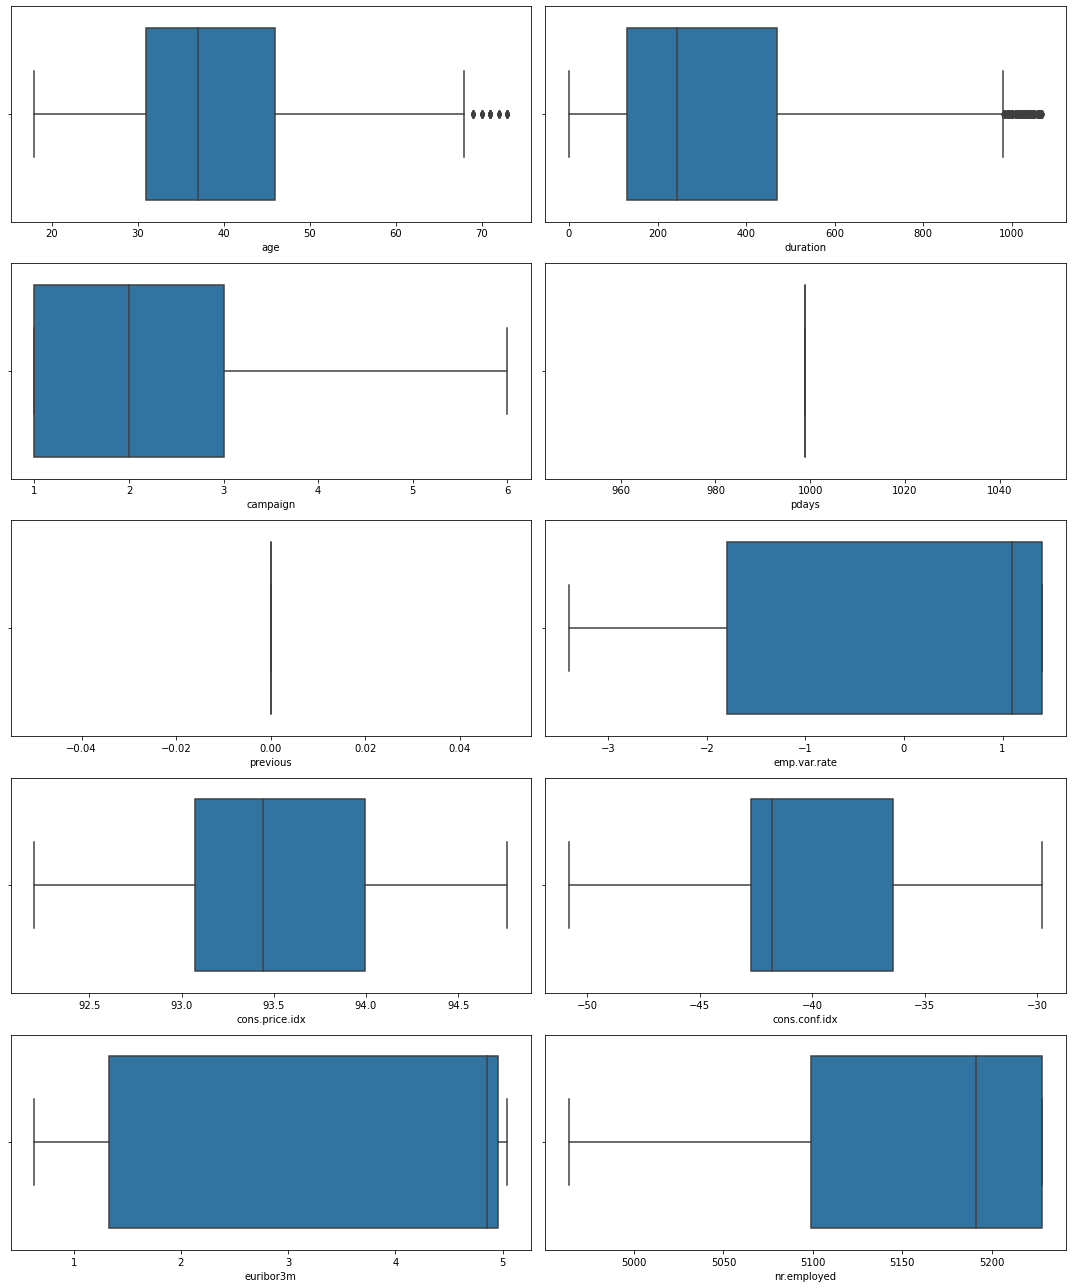

In [63]:
fig,ax = plt.subplots(nrows = 5,ncols=2,figsize = (15,18))
for var, subplot in zip(bank_capped.columns[:-1],ax.flatten()):
    sns.boxplot(x = bank_capped[var],ax=subplot);
plt.tight_layout()

In [78]:
indep = bank_capped.drop('y',axis = 1)

In [70]:
def target(x):
    if x == 'no':
        return 0
    else:
        return 1

In [71]:
depen = bank_capped['y'].map(target)
depen

0       0
5       1
6       0
7       0
8       0
       ..
9634    1
9635    0
9636    0
9638    0
9639    0
Name: y, Length: 6555, dtype: int64

In [79]:
(indep=='unknown').sum()

age               0
duration          0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
dtype: int64

In [80]:
indep.isnull().sum()

age               0
duration          0
campaign          0
pdays             0
previous          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
dtype: int64

In [81]:
depen.isnull().sum()

0

In [86]:
indep.head(6)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,32,205,2,999,0,1.100000,93.994000,-36.400000,4.858000,5191.000000
5,25,243,3,999,0,-1.800000,92.843000,-50.000000,1.531000,5099.100000
6,36,214,1,999,0,-0.100000,93.200000,-42.000000,4.120000,5195.800000
7,43,550,1,999,0,1.100000,93.994000,-36.400000,4.857000,5191.000000
8,52,64,1,999,0,1.100000,93.994000,-36.400000,4.855000,5191.000000
9,34,302,1,999,0,-2.900000,92.963000,-40.800000,1.260000,5076.200000


In [83]:
indep.var()

age                103.732072
duration         64214.958630
campaign             1.647471
pdays                0.000000
previous             0.000000
emp.var.rate         2.646893
cons.price.idx       0.342380
cons.conf.idx       21.712605
euribor3m            3.167212
nr.employed       5540.087617
dtype: float64

In [84]:
indep.nunique()

age                56
duration          999
campaign            6
pdays               1
previous            1
emp.var.rate       10
cons.price.idx     25
cons.conf.idx      25
euribor3m         275
nr.employed        11
dtype: int64

In [88]:
indep = indep.drop(['pdays','previous'],axis=1)

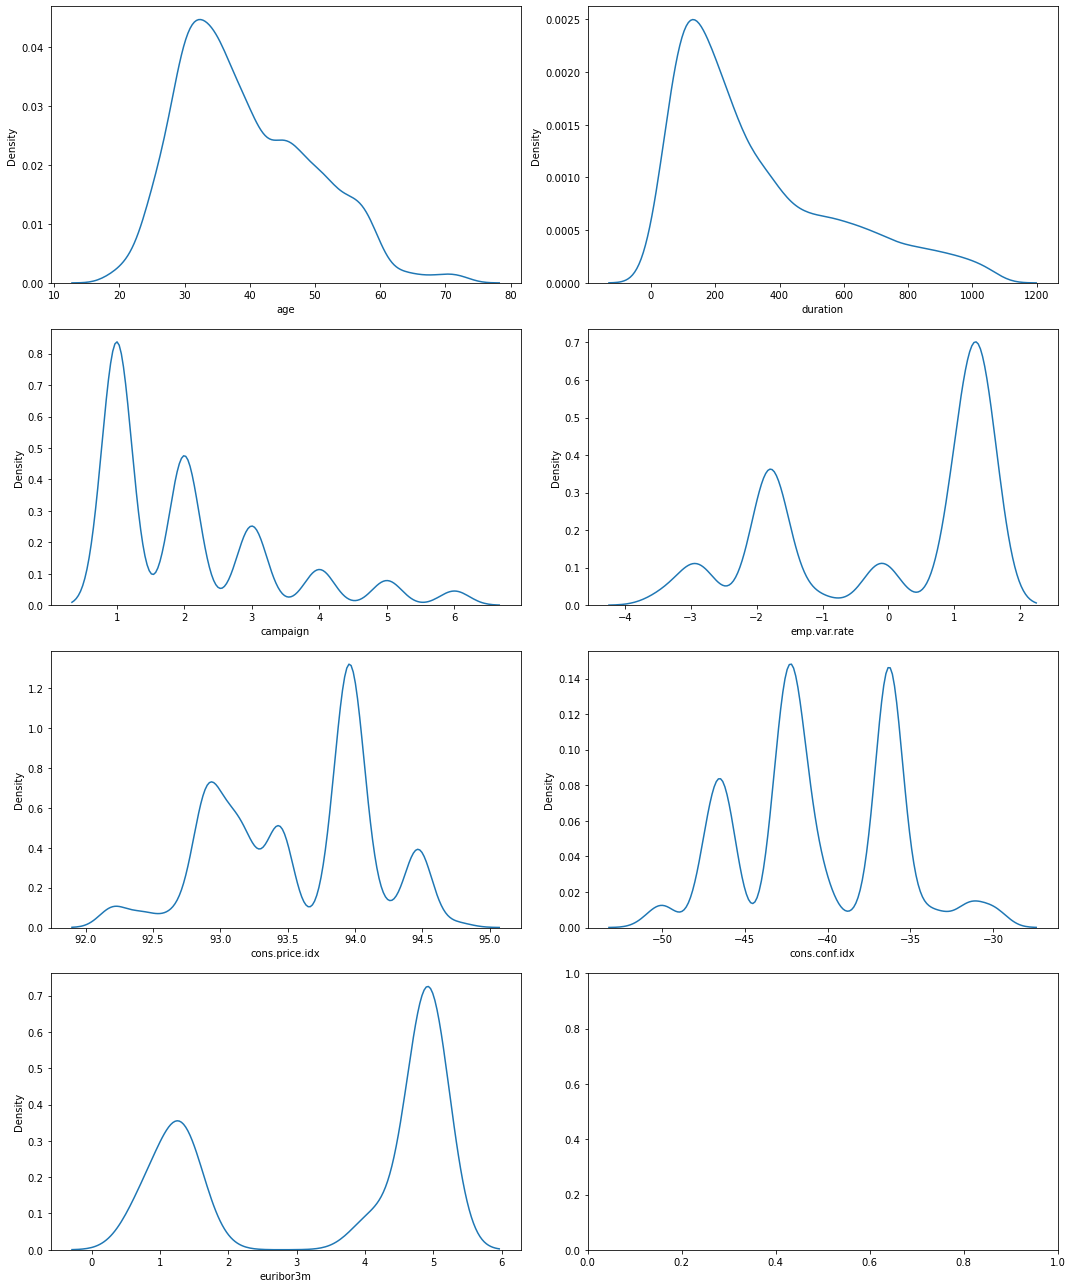

In [92]:
fig,ax = plt.subplots(nrows = 4,ncols=2,figsize = (15,18))
for var, subplot in zip(indep.columns[:-1],ax.flatten()):
    sns.kdeplot(x = indep[var],ax=subplot);
plt.tight_layout()

In [93]:
indep.skew()

age               0.598601
duration          1.041608
campaign          1.324147
emp.var.rate     -0.575913
cons.price.idx   -0.214375
cons.conf.idx     0.104692
euribor3m        -0.545969
nr.employed      -0.880652
dtype: float64

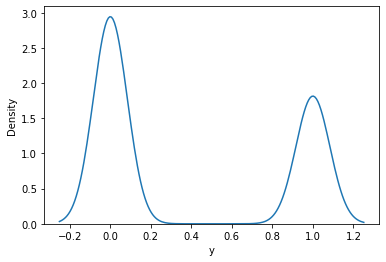

In [94]:
sns.kdeplot(depen);

In [95]:
depen.skew()

0.48849976410268137

In [100]:
ss = StandardScaler()
scaled = pd.DataFrame(ss.fit_transform(indep),columns=indep.columns)

<a id="knn"> </a>
## 2. K Nearest Neighbors (KNN)

## We shall use the bank marketing dataset that we cleaned above

Before applying classification techniques to predict whether the client subscribed the term deposit or not, let us split the dataset in train and test set.

In [130]:
train_x,test_x,train_y,test_y = train_test_split(indep,depen,random_state=10)

#### Define a function to plot the confusion matrix.

In [270]:
def confusion_matrix1(model,train_x,test_x):
    y_predict = model.predict(train_x)
    y_predict_test = model.predict(test_x)
    conf = confusion_matrix(test_y,y_predict_test)
    conf_matrix = pd.DataFrame(conf,columns=['PREDICTED 0','PREDICTED 1'],index=['ACTUAL 0','ACTUAL 1'])
    return sns.heatmap(conf_matrix,annot=True,fmt = 'd',cmap = 'Blues')

#### Define a function to plot the ROC curve.

In [132]:
def roc_auc_(model):
    y_predict = model.predict(train_x)
    y_predict_test = model.predict(test_x)
    fpr,tpr,threshold = roc_curve(test_y,y_predict_test)
    return plt.plot([0,1],[0,1])
    return plt.plot(fpr,tpr)
    return plt.text(x = 0.1,y = 0.95,s = roc_auc_score(test_y,y_predict_test))

In [230]:
knn = KNeighborsClassifier(n_neighbors=3,weights='distance',metric='euclidean')

In [231]:
model1 = knn.fit(train_x,train_y)

In [232]:
y_pred = knn.predict(train_x)

In [233]:
y_pred_test = knn.predict(test_x)

In [234]:
accuracy_score(test_y,y_pred_test)

0.8364856619890177

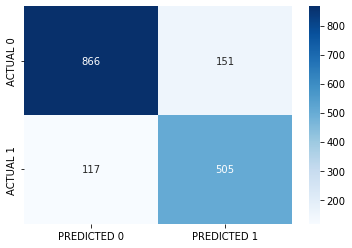

In [271]:
confusion_matrix1(model1,train_x,test_x);

Given list of values:

    n_neighbors = np.arange(1, 25, 2)
    metric = ['hamming','euclidean','manhattan','Chebyshev']

In [249]:
tune_pram = [{'n_neighbors':np.arange(1,25,2),'metric':['hamming','euclidean','manhattan','Chebyshev']}]

In [250]:
knn_ = KNeighborsClassifier(n_jobs=-1)

In [251]:
knn_grid1 = GridSearchCV(estimator=knn_,param_grid=tune_pram,scoring='roc_auc',cv = 3,verbose=3,return_train_score=True)

In [252]:
knn_grid.fit(train_x,train_y)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_jobs=-1),
             param_grid=[{'metric': ['hamming', 'euclidean', 'manhattan',
                                     'chebyshev'],
                          'n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23])}],
             scoring='roc_auc')

In [253]:
knn_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': 19}

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>13.  Build a KNN model with the best parameters and find the accuracy. Also generate a classification report.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [254]:
knn_n = KNeighborsClassifier(metric='manhattan',n_neighbors = 19)

In [255]:
knn_n.fit(train_x,train_y)

KNeighborsClassifier(metric='manhattan', n_neighbors=19)

In [298]:
y_pred_train = knn_n.predict(train_x)
y_pred_test = knn_n.predict(test_x)

In [300]:
fpr,tpr,threshold = roc_curve(test_y,y_pred_test)

In [299]:
accuracy_score(train_y,y_pred_train)

0.8696094385679414

In [257]:
accuracy_score(test_y,y_pred_test)

0.8541793776693105

In [265]:
print(classification_report(train_y,y_pred_train))
print(classification_report(test_y,y_pred_test))

              precision    recall  f1-score   support

           0       0.89      0.90      0.89      3038
           1       0.83      0.82      0.83      1878

    accuracy                           0.87      4916
   macro avg       0.86      0.86      0.86      4916
weighted avg       0.87      0.87      0.87      4916

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      1017
           1       0.80      0.82      0.81       622

    accuracy                           0.85      1639
   macro avg       0.84      0.85      0.85      1639
weighted avg       0.85      0.85      0.85      1639



In [266]:
roc_auc_score(test_y,y_pred_test)

0.8469048680470586

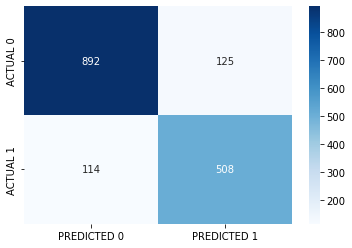

In [272]:
confusion_matrix1(knn_n,train_x,test_x);

In [269]:
conf = confusion_matrix(test_y,y_pred_test)

In [273]:
TP = conf[1,1]
TN = conf[0,0]
FN = conf[1,0]
FP = conf[0,1]
total = TP + TN + FP + FN

In [274]:
correctly_classified = (TN+TP)/total
misclassified = (FP+FN)/ total

In [277]:
accuracy_train  = []
accuracy_test  = []
for i in range(1,25):
    knn_test = KNeighborsClassifier(metric='euclidean',n_neighbors = i)    
    knn_test.fit(train_x,train_y)
    y_pred_train = knn_test.predict(train_x)
    y_pred_test = knn_test.predict(test_x)
    accuracy_test.append(accuracy_score(test_y,y_pred_test))
    accuracy_train.append(accuracy_score(train_y,y_pred_train))

Given list of values:

    n_neighbors = np.arange(1, 25, 2)

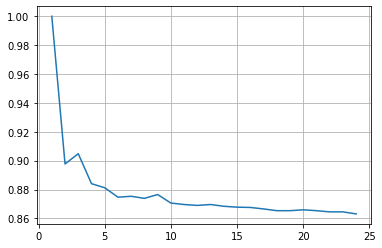

In [282]:
plt.plot(range(1,25),accuracy_train);
plt.grid(True)

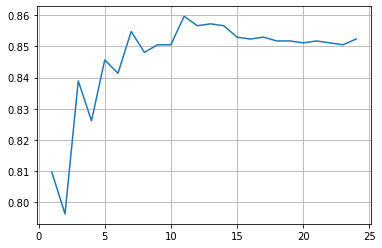

In [283]:
plt.plot(range(1,25),accuracy_test);
plt.grid(True)

In [ ]:
optimal k value is 11

<a id="nb"> </a>
## 3. Naive Bayes

<table align="left">
    <tr>
        <td width="6%">
            <img src="question_icon.png">
        </td>
        <td>
            <div align="left", style="font-size:120%">
                <font color="#21618C">
                    <b>18. Build a Gaussian naive bayes model and generate a classification report. Also tell how well is the model performing.</b>
                </font>
            </div>
        </td>
    </tr>
</table>

In [285]:
nb = GaussianNB()

In [286]:
nb.fit(train_x,train_y)

GaussianNB()

In [287]:
y_pred_bayes = nb.predict(train_x)
y_pred_test_bayes = nb.predict(test_x)

In [288]:
print(classification_report(train_y,y_pred_bayes))
print(classification_report(test_y,y_pred_test_bayes))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      3038
           1       0.69      0.80      0.74      1878

    accuracy                           0.78      4916
   macro avg       0.77      0.79      0.78      4916
weighted avg       0.79      0.78      0.79      4916

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      1017
           1       0.67      0.77      0.71       622

    accuracy                           0.77      1639
   macro avg       0.76      0.77      0.76      1639
weighted avg       0.78      0.77      0.77      1639



0.766429698343593


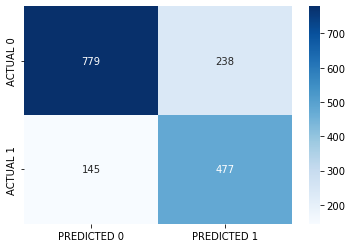

In [289]:
print(roc_auc_score(test_y,y_pred_test_bayes))
confusion_matrix1(nb,train_x,test_x);

In [290]:
new_nb = GaussianNB()
score = cross_val_score(estimator=new_nb,cv=10,X=train_x,y = train_y,scoring = 'accuracy')

In [291]:
score.mean()

0.7835701157418906

In [292]:
fpr_nb,tpr_nb,threshold_nb = roc_curve(test_y,y_pred_test_bayes)

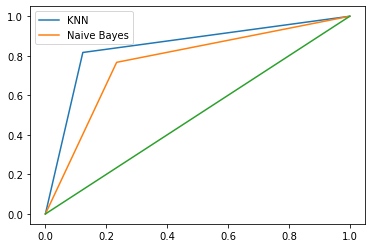

In [305]:
plt.plot(fpr,tpr,label='KNN')
plt.plot(fpr_nb,tpr_nb,label='Naive Bayes')
plt.plot([0,1],[0,1])
plt.legend();

In [ ]:
#KNN works better for this dataset